In [1]:
import os
!echo "CUDA Path: $CUDA_HOME"

CUDA Path: /software/spackages_v0_21_prod/apps/linux-ubuntu22.04-icelake/gcc-13.2.0/cuda-11.8.0-xod3wh3ft3br2z5fgm6hrkcz5vbx4a5u


In [2]:
cuda_path = "/software/spackages_v0_21_prod/apps/linux-ubuntu22.04-icelake/gcc-13.2.0/cuda-11.8.0-xod3wh3ft3br2z5fgm6hrkcz5vbx4a5u"
os.environ['CUDA_HOME'] = cuda_path
os.environ['CUDA_ROOT'] = cuda_path
os.environ['CUDA_PATH'] = cuda_path
os.environ['LD_LIBRARY_PATH'] = f"{cuda_path}/lib64:" + os.environ.get('LD_LIBRARY_PATH', '')
os.environ['XLA_FLAGS'] = f'--xla_gpu_cuda_data_dir={cuda_path}'

#Verify CUDA installation (using Python, not shell variables)
print("Checking CUDA files:")
# Use Python to check the directory
import os
libdevice_path = os.path.join(cuda_path, "nvvm", "libdevice")
if os.path.exists(libdevice_path):
    print(f"Found libdevice directory: {libdevice_path}")
    print("Contents:", os.listdir(libdevice_path))
else:
    print(f"ERROR: Directory not found: {libdevice_path}")
    print("Try finding libdevice with:")
    print(f"!find {cuda_path} -name 'libdevice.10.bc' 2>/dev/null")

# Cell 3: Direct shell command (no Python variables)
print("\nDirect shell check:")
!ls /software/spackages_v0_21_prod/apps/linux-ubuntu22.04-icelake/gcc-13.2.0/cuda-11.8.0-xod3wh3ft3br2z5fgm6hrkcz5vbx4a5u

Checking CUDA files:
Found libdevice directory: /software/spackages_v0_21_prod/apps/linux-ubuntu22.04-icelake/gcc-13.2.0/cuda-11.8.0-xod3wh3ft3br2z5fgm6hrkcz5vbx4a5u/nvvm/libdevice
Contents: ['libdevice.10.bc']

Direct shell check:
bin		   gds	     nsight-compute-2022.3.0  pkgconfig  tools
compute-sanitizer  gds-11.8  nsightee_plugins	      README	 version.json
DOCS		   include   nsight-systems-2022.4.2  share
EULA.txt	   lib64     nvml		      src
extras		   libnvvp   nvvm		      targets


In [3]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'

print(f"🔧 CUDA Configuration:")
print(f"   CUDA_HOME: {os.environ.get('CUDA_HOME')}")
print(f"   XLA_FLAGS: {os.environ.get('XLA_FLAGS')}")

libdevice_path = os.path.join(cuda_path, "nvvm", "libdevice", "libdevice.10.bc")
if os.path.exists(libdevice_path):
    print(f"   ✅ Found libdevice: {libdevice_path}")
else:
    print(f"   ❌ ERROR: libdevice not found at {libdevice_path}")

🔧 CUDA Configuration:
   CUDA_HOME: /software/spackages_v0_21_prod/apps/linux-ubuntu22.04-icelake/gcc-13.2.0/cuda-11.8.0-xod3wh3ft3br2z5fgm6hrkcz5vbx4a5u
   XLA_FLAGS: --xla_gpu_cuda_data_dir=/software/spackages_v0_21_prod/apps/linux-ubuntu22.04-icelake/gcc-13.2.0/cuda-11.8.0-xod3wh3ft3br2z5fgm6hrkcz5vbx4a5u
   ✅ Found libdevice: /software/spackages_v0_21_prod/apps/linux-ubuntu22.04-icelake/gcc-13.2.0/cuda-11.8.0-xod3wh3ft3br2z5fgm6hrkcz5vbx4a5u/nvvm/libdevice/libdevice.10.bc


## Import Libraries

In [4]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file

from stardist import relabel_image_stardist3D, Rays_GoldenSpiral, calculate_extents
from stardist import fill_label_holes, random_label_cmap
from stardist.matching import matching_dataset

np.random.seed(42)
lbl_cmap = random_label_cmap()

bioimageio_utils.py (2): pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


## Loading the data

In [5]:
# Load full multi-frame images and labels
image_path = '../Image_Data/old/Top_30_Microns.tif'
label_path2 =  '../Image_Data/old/LblImg_Top_30_Microns.tif'

image_stack = imread(image_path, mode='r')  # Shape: (30, 2048, 2048)
label_stack2 = imread(label_path2, mode='r')
label_stack2 = np.round(label_stack2).astype(int)

In [6]:
print(np.unique(label_stack2))

[  -1    0    1 ... 2776 2777 2778]


In [7]:
print(f"Shape of the image stack: {image_stack.shape}")  # (z, y, x)
print(f"Shape of the label stack 2: {label_stack2.shape}")  # (z, y, x)

Shape of the image stack: (31, 2048, 2048)
Shape of the label stack 2: (31, 2048, 2048)


In [8]:
# Define cropping parameters (selecting only 10 frames and a 512x512 region)
z_start, z_end = 0, 16  # First 15 frames
x_start, x_end = 1000, 1512  # Crop along X
y_start, y_end = 1000, 1512  # Crop along Y

In [9]:
selected_frames = image_stack[z_start:z_end, x_start:x_end, y_start:y_end]
selected_labels = label_stack2[z_start:z_end, x_start:x_end, y_start:y_end]

In [10]:
selected_frames.ndim

3

In [11]:
selected_labels = np.where(selected_labels == -1, 0, selected_labels)

In [12]:
print(f"Shape of the cropped image stack: {selected_frames.shape}")  # (z, y, x)
print(f"Shape of the cropped label stack: {selected_labels.shape}")  # (z, y, x)

Shape of the cropped image stack: (16, 512, 512)
Shape of the cropped label stack: (16, 512, 512)


In [13]:
def visualize_slices(image_stack, label_stack, num_slices=3):
    """
    Displays `num_slices` image-label pairs from the given 3D stacks.
    
    Parameters:
        image_stack (numpy array): Cropped 3D image array (Z, X, Y)
        label_stack (numpy array): Cropped 3D label array (Z, X, Y)
        num_slices (int): Number of slices to display
    """
    # Get total number of frames
    total_slices = image_stack.shape[0]
    
    # Select evenly spaced slices
    selected_slices = np.linspace(0, total_slices - 1, num_slices, dtype=int)

    # Create figure
    fig, axes = plt.subplots(num_slices, 2, figsize=(10, 3 * num_slices))

    for i, z in enumerate(selected_slices):
        # Show raw image
        axes[i, 0].imshow(image_stack[z], cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"Image Slice {z}")

        # Show label mask
        axes[i, 1].imshow(label_stack[z], cmap='magma', alpha=0.6)  # Overlay with color
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"Label Slice {z}")

    plt.tight_layout()
    plt.show()

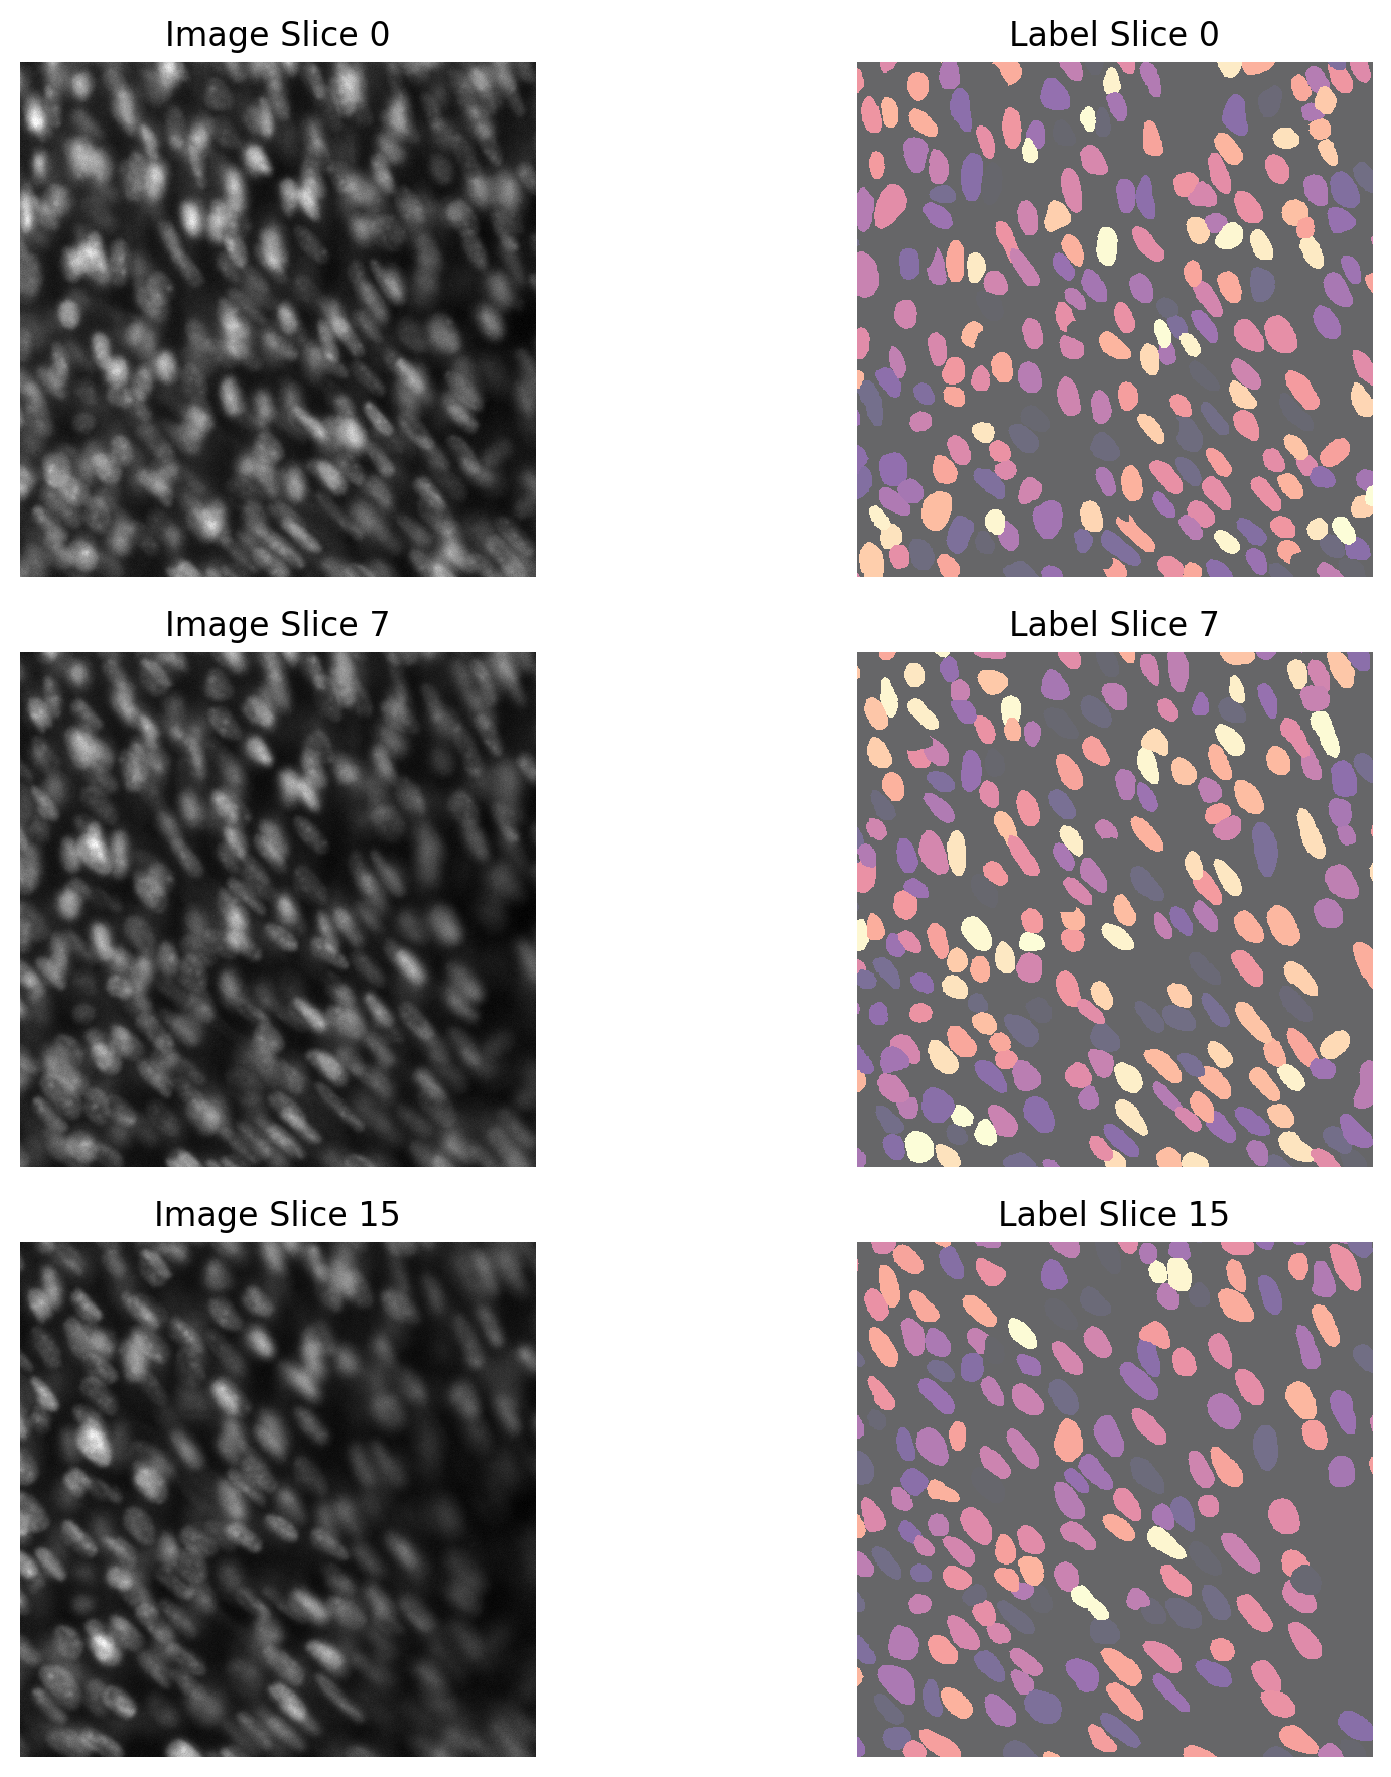

In [14]:
# Call function to view slices
visualize_slices(selected_frames, selected_labels, num_slices=3)

In [15]:
# Directly use the selected cropped image and label stacks
extents = calculate_extents(selected_labels)  # Compute anisotropy directly on selected_labels
anisotropy = tuple(np.max(extents) / extents)

print('Empirical anisotropy of labeled objects = %s' % str(anisotropy))

Empirical anisotropy of labeled objects = (2.4375, 1.0, 1.1818181818181819)


## Fitting ground-truth labels with star-convex polyhedra

In [16]:
def reconstruction_scores(n_rays, anisotropy):
    scores = []
    for r in tqdm(n_rays):
        rays = Rays_GoldenSpiral(r, anisotropy=anisotropy)
        Y_reconstructed = [relabel_image_stardist3D(lbl, rays) for lbl in selected_labels]
        mean_iou = matching_dataset(Y, Y_reconstructed, thresh=0, show_progress=False).mean_true_score
        scores.append(mean_iou)
    return scores

In [17]:
def reconstruction_scores_2(n_rays, anisotropy):
    scores = []
    for r in tqdm(n_rays):
        rays = Rays_GoldenSpiral(r, anisotropy=anisotropy)
        
        # Pass the entire 3D stack (selected_labels) to relabel_image_stardist3D
        Y_reconstructed = relabel_image_stardist3D(selected_labels, rays)
        
        mean_iou = matching_dataset(selected_labels, Y_reconstructed, thresh=0, show_progress=False).mean_true_score
        scores.append(mean_iou)
    return scores


In [18]:
n_rays = [8, 16, 32, 64, 96, 128, 192, 256]
scores_iso   = reconstruction_scores_2(n_rays, anisotropy=None)
scores_aniso = reconstruction_scores_2(n_rays, anisotropy=anisotropy)

100%|██████████| 8/8 [01:13<00:00,  9.14s/it]


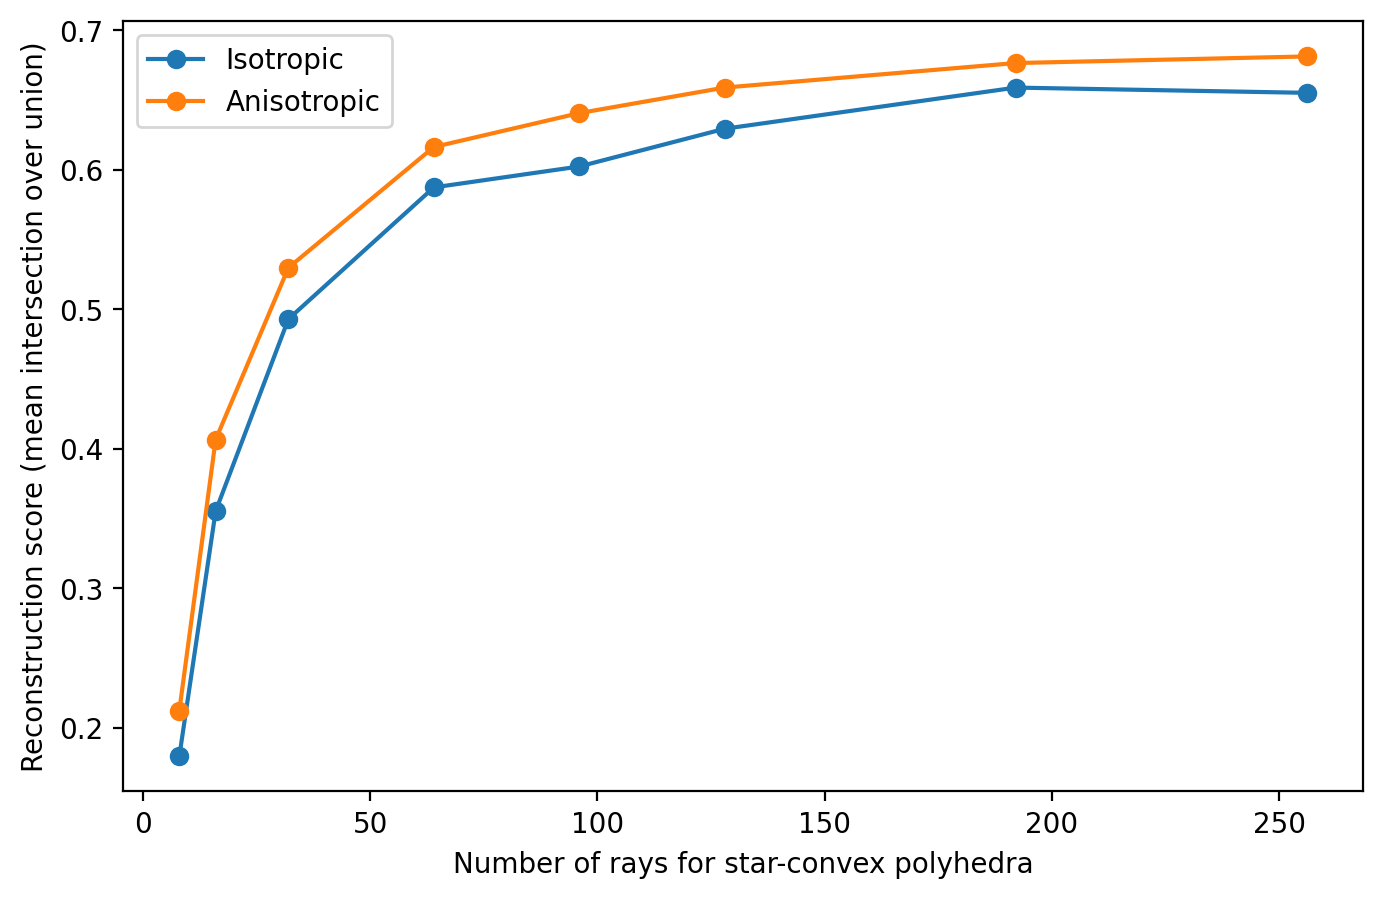

In [21]:
plt.figure(figsize=(8,5))
plt.plot(n_rays, scores_iso,   'o-', label='Isotropic')
plt.plot(n_rays, scores_aniso, 'o-', label='Anisotropic')
plt.xlabel('Number of rays for star-convex polyhedra')
plt.ylabel('Reconstruction score (mean intersection over union)')
plt.legend()
None;

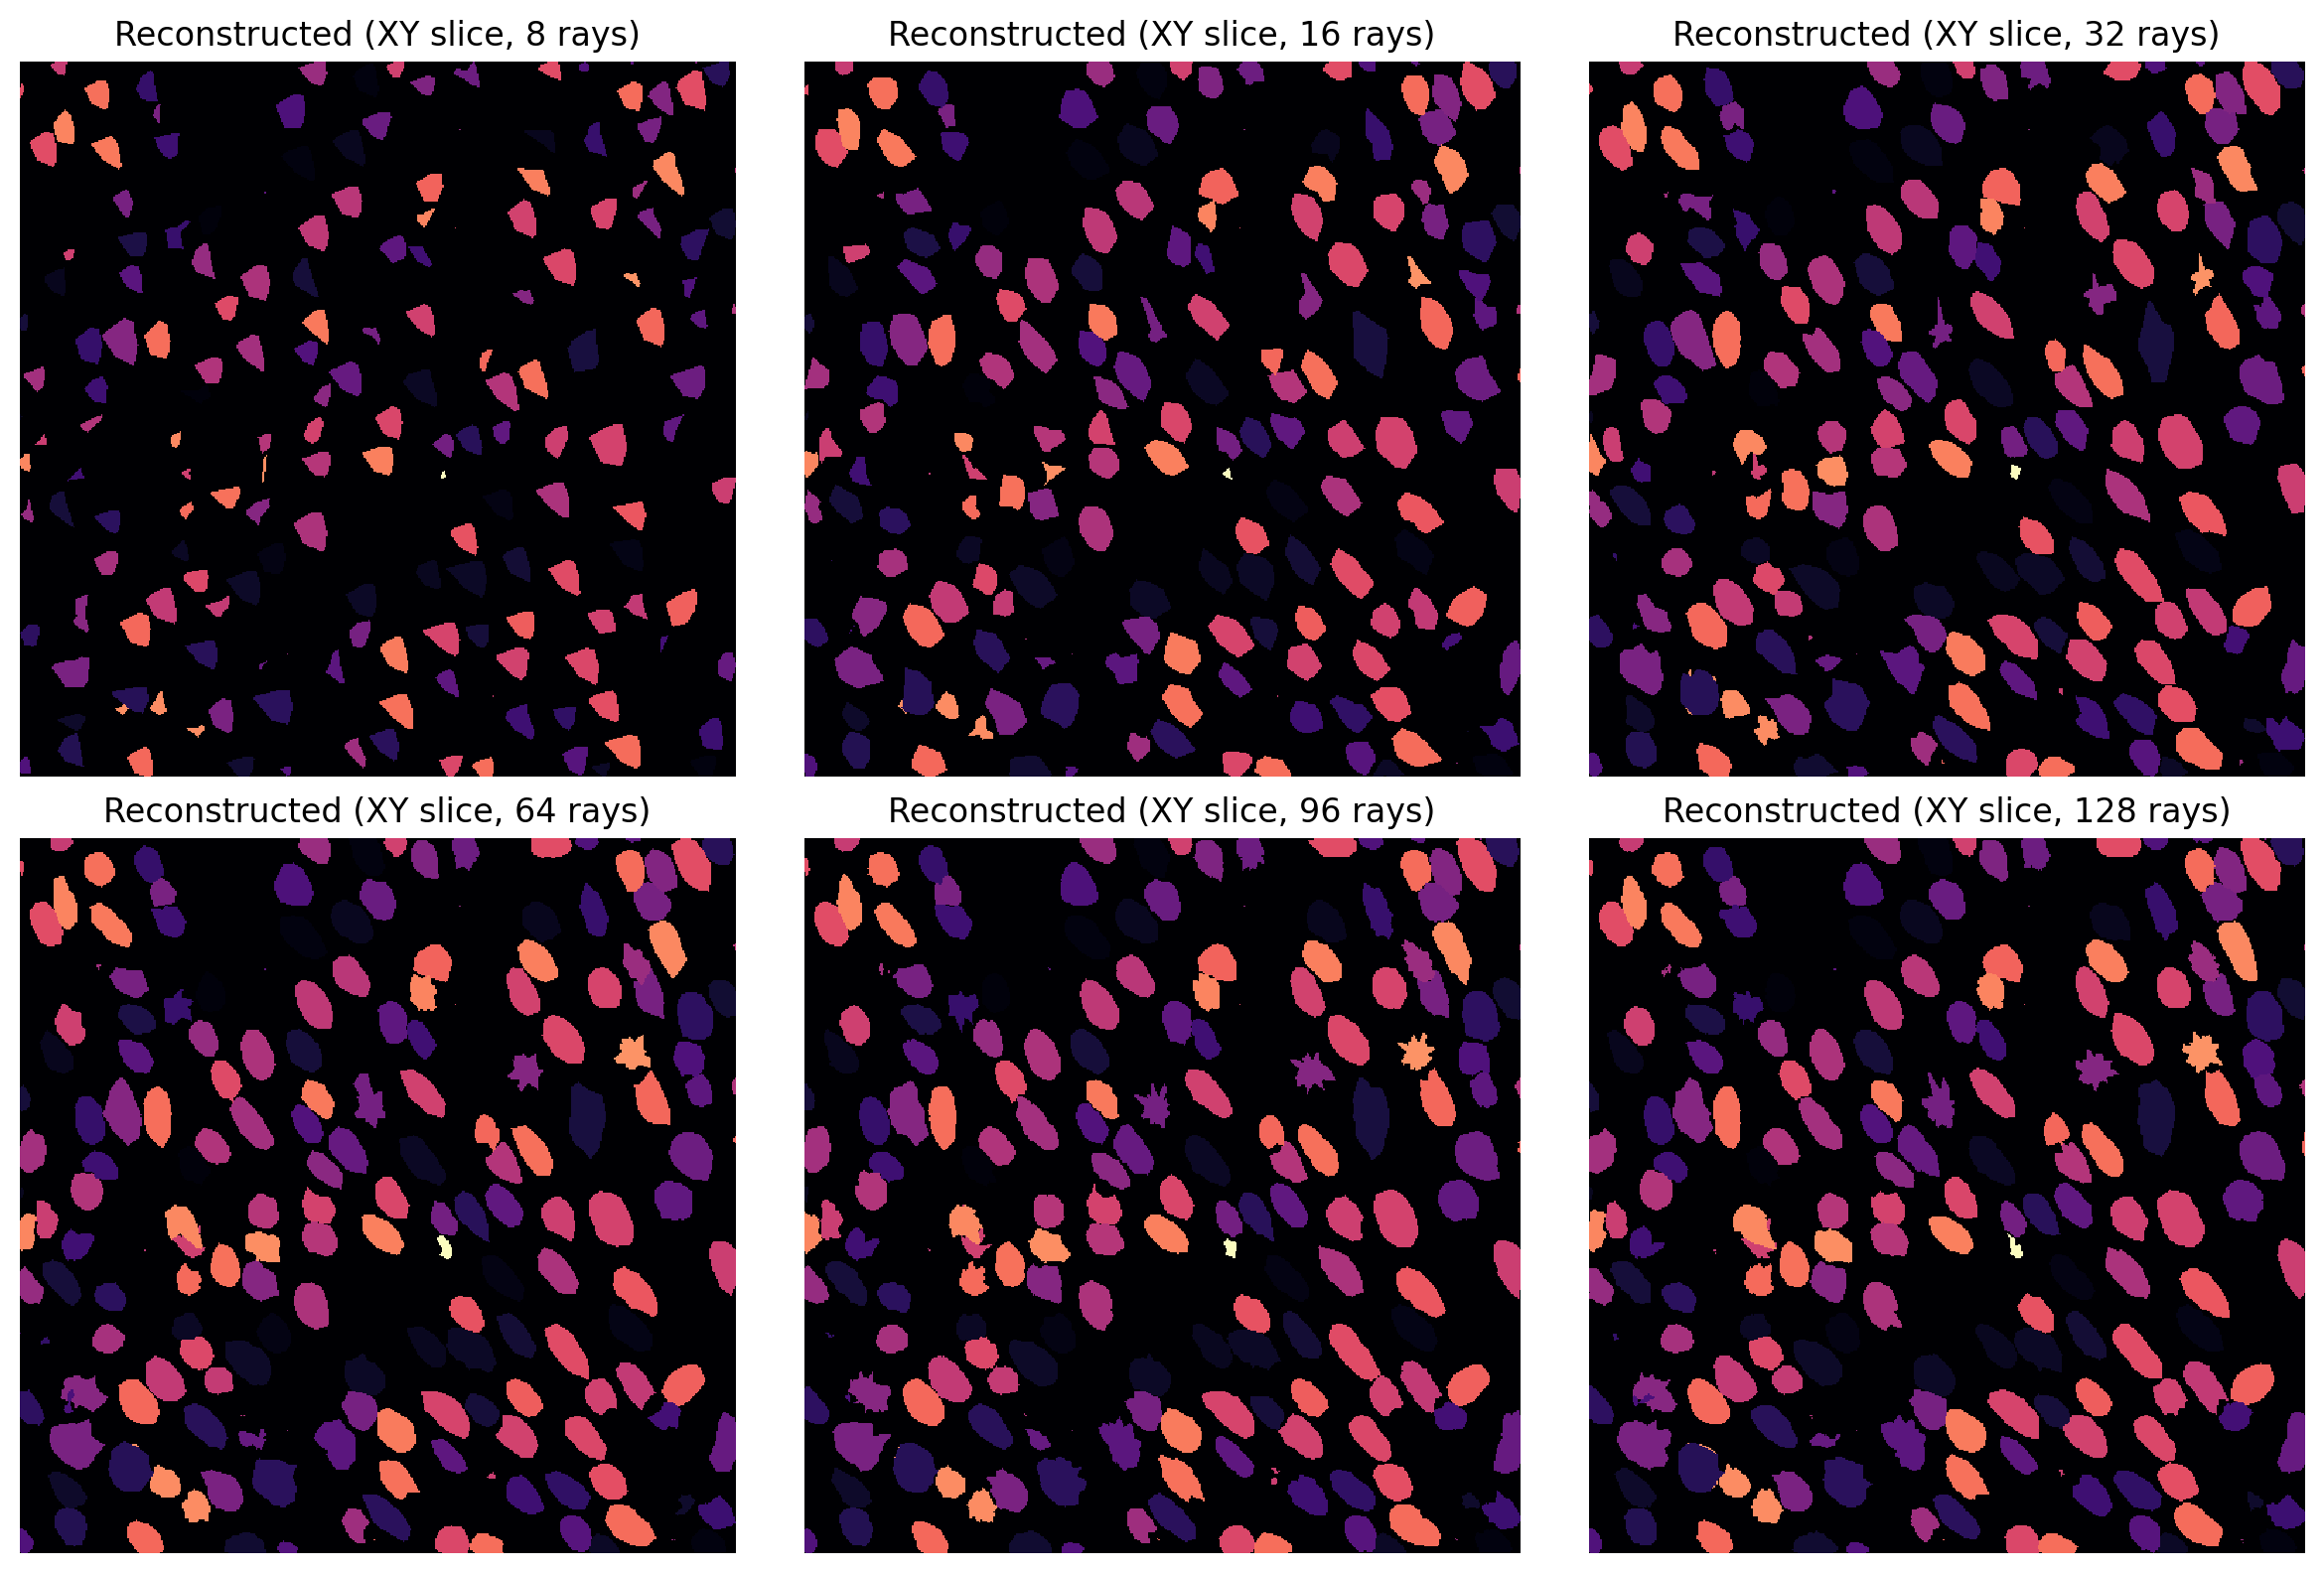

In [26]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

for a, r in zip(ax.flat, n_rays):
    # Get the middle slice of the 3D label stack
    z = selected_labels.shape[0] // 2  # Middle slice index
    
    # Generate rays for reconstruction
    rays = Rays_GoldenSpiral(r, anisotropy=anisotropy)
    
    # Perform the reconstruction and extract the middle slice for visualization
    Y_reconstructed = relabel_image_stardist3D(selected_labels, rays)
    a.imshow(Y_reconstructed[z], cmap="magma")  # Display the middle slice
    a.set_title(f'Reconstructed (XY slice, {r} rays)')
    a.axis('off')

plt.tight_layout()

## Making Predictions uding stardist 3d model

In [27]:
from stardist.models import StarDist3D

StarDist3D.from_pretrained()

There is 1 registered model for 'StarDist3D':

Name        Alias(es)
────        ─────────
'3D_demo'   None


In [28]:
model3d = StarDist3D.from_pretrained('3D_demo')

Found model '3D_demo' for 'StarDist3D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.707933, nms_thresh=0.3.


In [29]:
import numpy as np
from csbdeep.utils import Path, normalize

# Function to normalize a 3D stack (frame by frame)
def normalize_frames(frames, pmin, pmax, axis=None):
    # Rescale each frame in the stack individually
    return np.array([normalize(frame, pmin, pmax, axis=axis) for frame in frames])

# Assuming selected_frames is a 3D array (e.g., shape = (n_frames, height, width))
#normalized_frames = normalize_frames(selected_frames, 1, 99.8, axis=1)  # Normalizing along the frames axis
normalized_frames = normalize_frames(image_stack, 1, 99.8, axis=1)

In [30]:
normalized_frames.shape

(31, 2048, 2048)

In [31]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("cuDNN version:", tf.sysconfig.get_build_info()["cudnn_version"])
print("GPU:", tf.test.gpu_device_name())

TensorFlow version: 2.14.0
cuDNN version: 8
GPU: /device:GPU:0


2025-06-27 10:00:38.425468: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 3076 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 1g.5gb, pci bus id: 0000:17:00.0, compute capability: 8.0


In [32]:
import tensorflow as tf
print("GPUs:", tf.config.list_physical_devices('GPU'))
gpu = tf.config.list_physical_devices('GPU')[0]
print("Memory growth:", tf.config.experimental.get_memory_growth(gpu))

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Memory growth: None


In [33]:
import numpy as np
import time

# Ensure normalized_frames is 4D (add channel dimension if needed)
if normalized_frames.ndim == 3:
    normalized_frames = normalized_frames[..., np.newaxis]  # Add channel dimension
    print(f"Added channel dimension. New shape: {normalized_frames.shape}")

# Define tile sizes (including channel dimension)
tile_z = 16    # Depth
tile_y = 256   # Height
tile_x = 256   # Width
tile_c = 1     # Channels (always 1)

# Calculate number of tiles needed in each dimension
n_tiles_z = max(1, int(np.ceil(normalized_frames.shape[0] / tile_z)))
n_tiles_y = max(1, int(np.ceil(normalized_frames.shape[1] / tile_y)))
n_tiles_x = max(1, int(np.ceil(normalized_frames.shape[2] / tile_x)))
n_tiles_c = max(1, int(np.ceil(normalized_frames.shape[3] / tile_c)))

print(f"Input shape: {normalized_frames.shape}")
print(f"Using tile grid: Z={n_tiles_z}, Y={n_tiles_y}, X={n_tiles_x}, C={n_tiles_c}")

# Run prediction with tiling
start_time = time.time()
labels, details = model3d.predict_instances(
    normalized_frames,
    n_tiles=(n_tiles_z, n_tiles_y, n_tiles_x, n_tiles_c),  # 4-tuple
    show_tile_progress=True,
    prob_thresh=0.5
)
end_time = time.time()
print(f"Time taken: {end_time - start_time:.2f} seconds")

Added channel dimension. New shape: (31, 2048, 2048, 1)
Input shape: (31, 2048, 2048, 1)
Using tile grid: Z=2, Y=8, X=8, C=1


2025-06-27 10:00:54.020338: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
  0%|          | 0/64 [00:00<?, ?it/s]2025-06-27 10:01:10.513657: W tensorflow/tsl/framework/bfc_allocator.cc:366] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2025-06-27 10:01:10.640158: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.44GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2

Time taken: 647.28 seconds


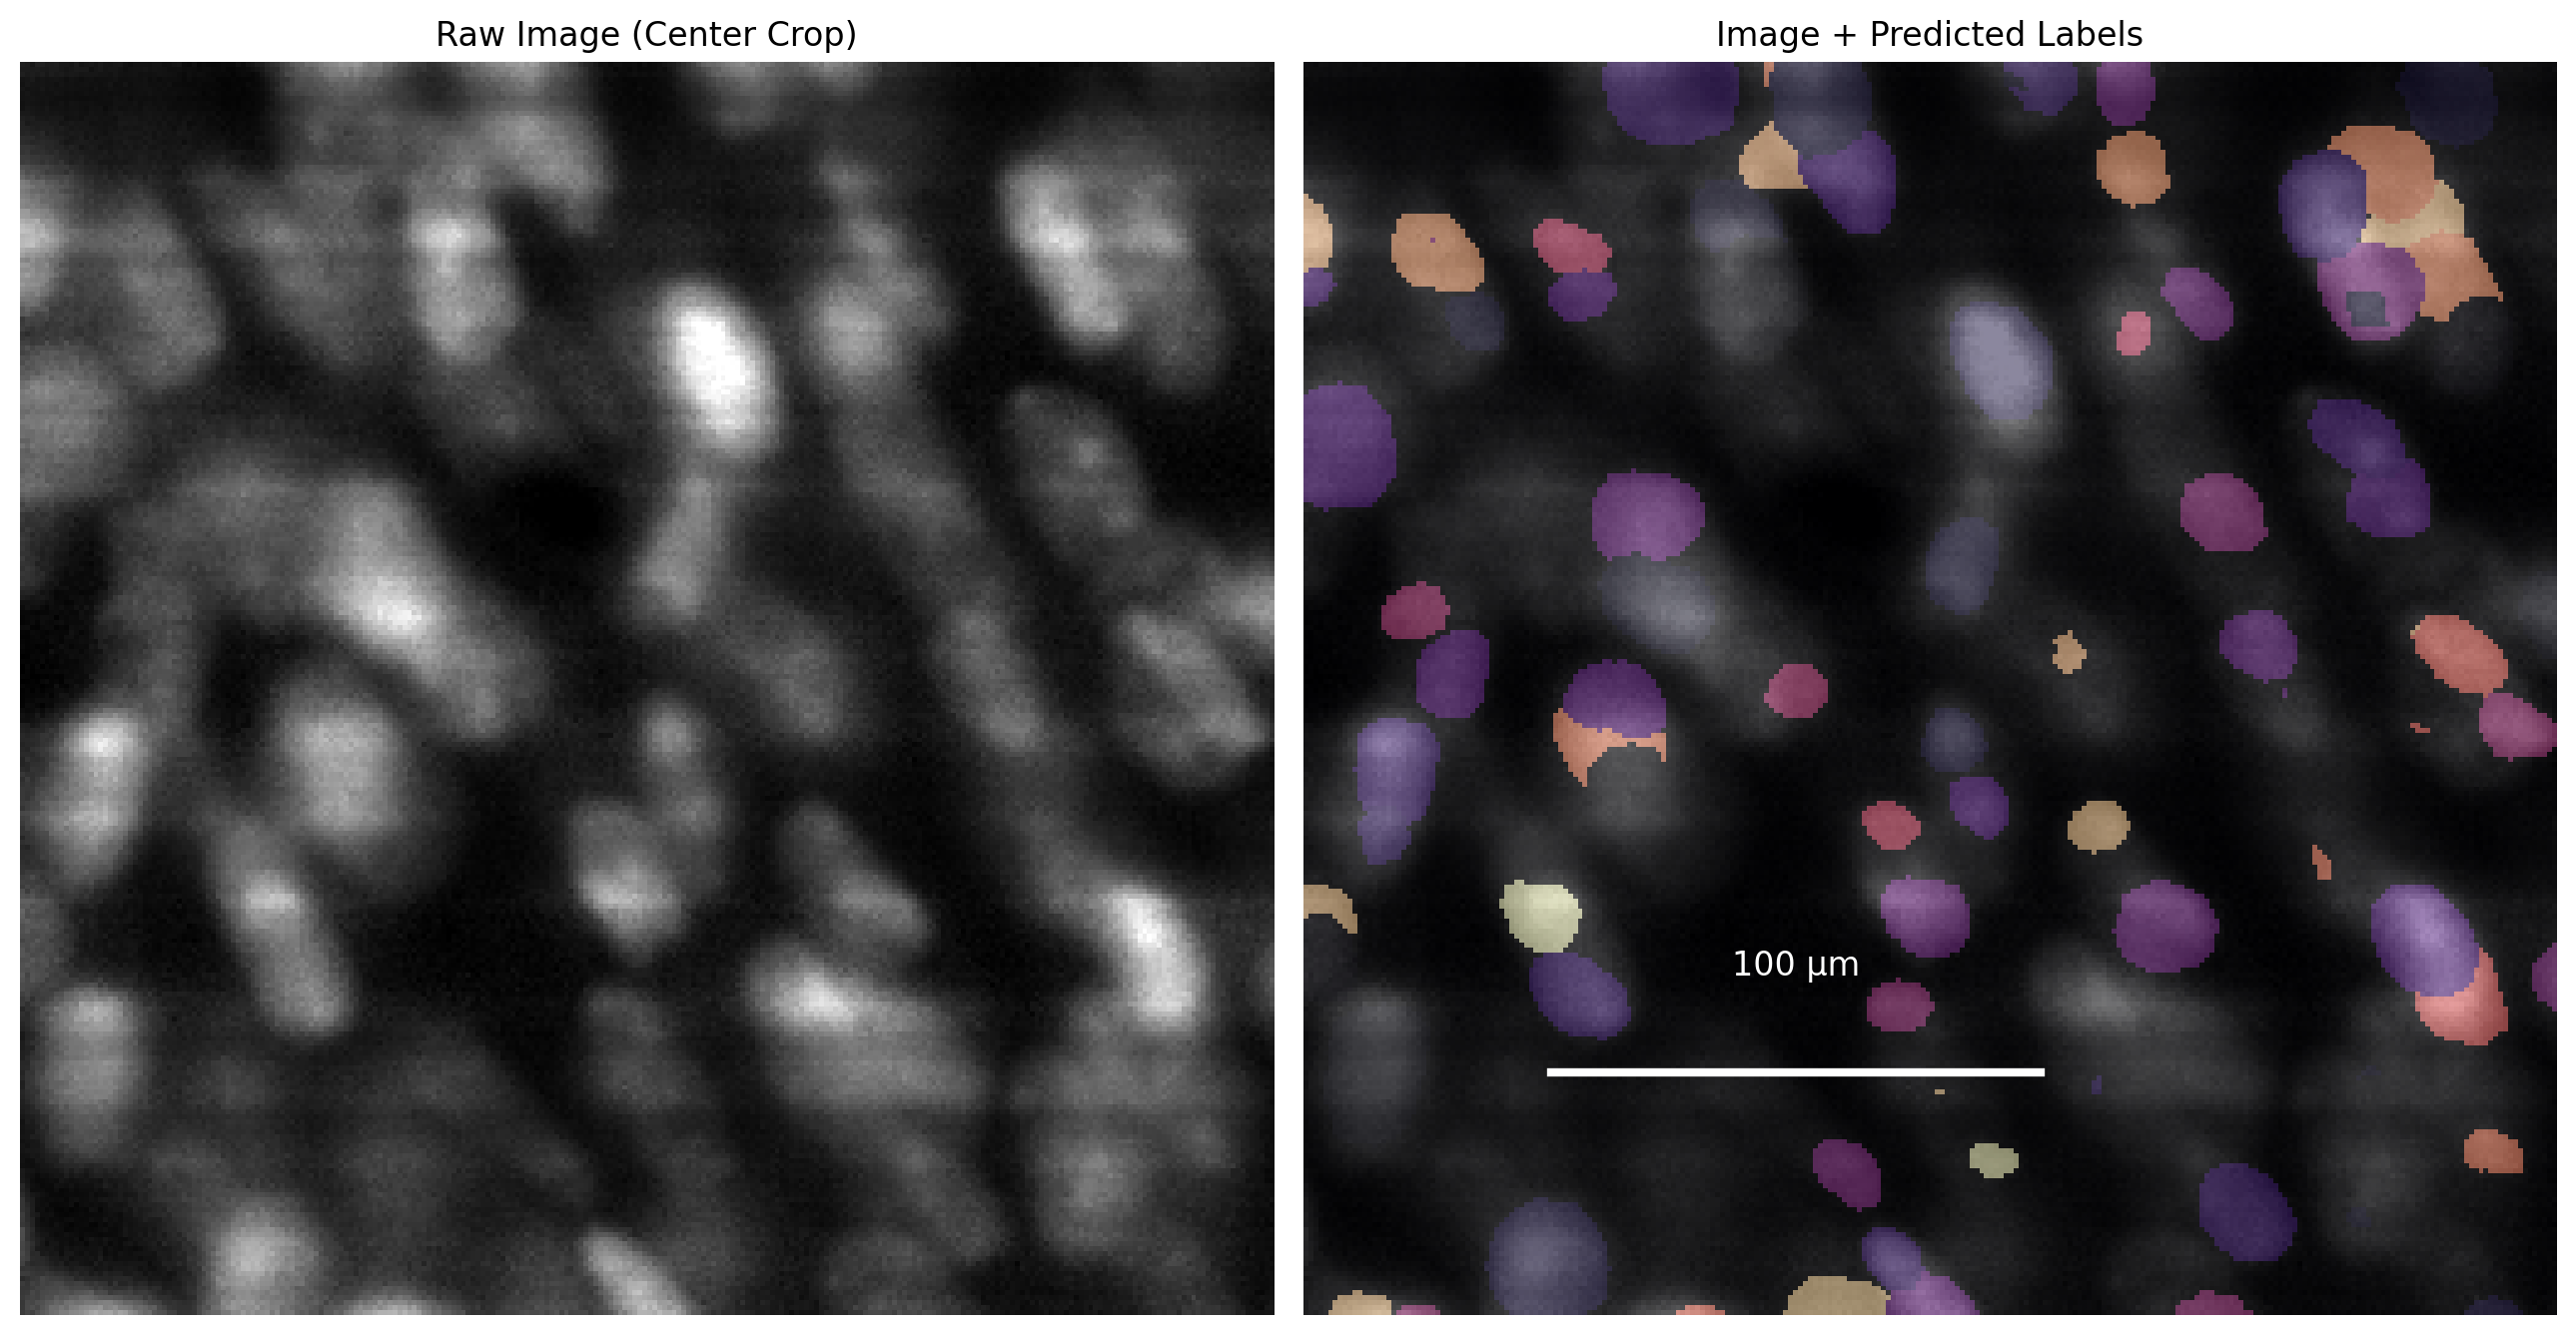

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Create a custom colormap for labels
lbl_cmap = ListedColormap(np.random.rand(256, 3))

# Select a z-slice near the middle
z = max(0, normalized_frames.shape[0] // 2 - 5)

# Define a smaller region of interest (center crop)
crop_size = 256  # Size of the crop in pixels
y_center = normalized_frames.shape[1] // 2
x_center = normalized_frames.shape[2] // 2

y_start = max(0, y_center - crop_size//2)
y_end = min(normalized_frames.shape[1], y_center + crop_size//2)
x_start = max(0, x_center - crop_size//2)
x_end = min(normalized_frames.shape[2], x_center + crop_size//2)

# Create the figure
plt.figure(figsize=(8, 6))

# Raw image
plt.subplot(121)
if normalized_frames.ndim == 3:
    plt.imshow(normalized_frames[z, y_start:y_end, x_start:x_end], 
               cmap='gray', clim=(0, 1))
else:
    # For multi-channel, show first channel
    plt.imshow(normalized_frames[z, y_start:y_end, x_start:x_end, 0], 
               cmap='gray', clim=(0, 1))
plt.title('Raw Image (Center Crop)')
plt.axis('off')

# Overlay
plt.subplot(122)
if normalized_frames.ndim == 3:
    plt.imshow(normalized_frames[z, y_start:y_end, x_start:x_end], 
               cmap='gray', clim=(0, 1))
else:
    plt.imshow(normalized_frames[z, y_start:y_end, x_start:x_end, 0], 
               cmap='gray', clim=(0, 1))

# Overlay labels with transparency
plt.imshow(labels[z, y_start:y_end, x_start:x_end], 
           cmap='magma', alpha=0.5, interpolation='nearest')

plt.title('Image + Predicted Labels')
plt.axis('off')

# Add scale bar (assuming 1px = 1µm for example)
scale_bar_size = 100  # in microns
plt.plot([50, 50 + scale_bar_size], [crop_size - 50, crop_size - 50], 
         'w-', linewidth=3)
plt.text(50 + scale_bar_size/2, crop_size - 70, f"{scale_bar_size} µm", 
         color='white', ha='center', fontsize=12)

plt.tight_layout()
plt.show()

In [35]:
gt_labels = label_stack2

In [36]:
assert gt_labels.shape == labels.shape, f"Shape mismatch: GT {gt_labels.shape} vs Pred {labels.shape}"

In [37]:
print("GT labels dtype:", gt_labels.dtype)
print("Pred labels dtype:", labels.dtype)

GT labels dtype: int64
Pred labels dtype: int32


In [38]:
gt_labels = gt_labels.astype(np.uint32)
print(f"GT dtype: {gt_labels.dtype}, Pred dtype: {labels.dtype}")
print(f"GT unique: {np.unique(gt_labels)}, Pred unique: {np.unique(labels)}")

GT dtype: uint32, Pred dtype: int32
GT unique: [         0          1          2 ...       2777       2778 4294967295], Pred unique: [   0    1    2 ... 9508 9509 9510]


In [39]:
# Calculating instance counts
n_gt = len(np.unique(gt_labels)) - 1
n_pred = len(np.unique(labels)) - 1
print(f"\nInstance Counts:\n- Ground Truth: {n_gt}\n- Prediction: {n_pred}")


Instance Counts:
- Ground Truth: 2779
- Prediction: 9510


In [41]:
from stardist.matching import matching

# Compute metrics
metrics = matching(gt_labels, labels, thresh=0.5)

print("\n===== StarDist 3D Evaluation Metrics =====")
print(f"F1 Score: {metrics.f1:.6f}")
print(f"Precision: {metrics.precision:.6f}")
print(f"Recall: {metrics.recall:.6f}")
print(f"Accuracy: {metrics.accuracy:.6f}")
print(f"True Positives (TP): {metrics.tp}")
print(f"False Positives (FP): {metrics.fp}")
print(f"False Negatives (FN): {metrics.fn}")
print(f"Number of GT objects: {metrics.n_true}")
print(f"Number of Predicted objects: {metrics.n_pred}")
print(f"Average IoU of matched objects: {metrics.mean_matched_score:.4f}")

# Calculate error rate
error_rate = (metrics.fp + metrics.fn) / metrics.n_true * 100
print(f"\nError Rate: {error_rate:.1f}%")


===== StarDist 3D Evaluation Metrics =====
F1 Score: 0.003418
Precision: 0.002208
Recall: 0.007557
Accuracy: 0.001712
True Positives (TP): 21
False Positives (FP): 9489
False Negatives (FN): 2758
Number of GT objects: 2779
Number of Predicted objects: 9510
Average IoU of matched objects: 0.5509

Error Rate: 440.7%


In [60]:
metrics

Matching(criterion='iou', thresh=0.5, fp=9489, tp=21, fn=2758, precision=0.0022082018927444794, recall=0.007556675062972292, accuracy=0.0017117704597326379, f1=0.0034176906176255186, n_true=2779, n_pred=9510, mean_true_score=0.004163081116623139, mean_matched_score=0.5509144010997954, panoptic_quality=0.0018828549797535524)